In [1]:
import numpy as np
from scipy.signal import hilbert, butter, filtfilt, lfilter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import matplotlib.pyplot as plt


In [146]:
np.random.seed(42)

# Параметры
Fs = 512  # Частота дискретизации
T = 1000  # Общее время симуляции (в секундах)
N_EMG = 8  # Количество каналов ЭМГ
N_joints = 1  # Количество декодируемых углов

# Временной вектор
t = np.linspace(0, T, int(Fs * T))

# Функция для создания фильтра
def butter_filter(order, cutoff, btype, fs):
    nyquist = fs / 2
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=btype)
    return b, a

# Задание фильтров
b_myo, a_myo = butter_filter(order=5, cutoff=[15, 150], btype='band', fs=Fs)
b_vel, a_vel = butter_filter(order=5, cutoff=2, btype='low', fs=Fs)
b_hp, a_hp = butter_filter(order=3, cutoff=0.1, btype='high', fs=Fs)

# Создание пространственной матрицы смешивания
A = np.random.randn(N_joints, N_EMG)

# Генерация сырых данных ЭМГ
s = filtfilt(b_myo, a_myo, np.random.randn(N_EMG, len(t)), axis=1)

# Вычисление модуля аналитического сигнала
analytic_signal = hilbert(s.T @ A.T)
envelope = np.abs(analytic_signal).T

# Применение фильтров к результату
vel1 = filtfilt(b_vel, a_vel, envelope, axis=1)
vel2 = filtfilt(b_hp, a_hp, filtfilt(b_vel, a_vel, envelope, axis=1), axis=1)

# Результаты
print("Размеры входного сигнала s:", s.shape)
print("Размеры выходного сигнала vel2:", vel2.shape)


Размеры входного сигнала s: (8, 512000)
Размеры выходного сигнала vel2: (1, 512000)


In [147]:
torch.manual_seed(42)

sample_size = 256

# signal_length = 512000
# s = torch.randn(signal_length, 8)  # Сигнал (512000, 8)
# A = torch.randn(1, 8)
# x = torch.matmul(s, A.T) # Выходной сигнал (512000, 1)
# x = torch.tensor(np.abs(hilbert(x)))

s = torch.tensor(s.T.copy(), dtype=torch.float32)
x = torch.tensor(envelope.T.copy(), dtype=torch.float32)

# x = torch.randn(signal_length, 1)  # Выходной сигнал (510977, 1)

# 1. Нарезка данных на сэмплы фиксированной длины
def create_samples(signal, labels, sample_size):
    num_samples = signal.shape[0] // sample_size
    signal_samples = signal[:num_samples * sample_size].view(num_samples, sample_size, -1)
    label_samples = labels[:num_samples * sample_size].view(num_samples, sample_size, -1)
    return signal_samples, label_samples

s_samples, x_samples = create_samples(s, x, sample_size)

# 2. Разделение на обучающую и валидационную выборки
train_ratio = 0.8
num_samples = s_samples.shape[0]
train_size = int(num_samples * train_ratio)
val_size = num_samples - train_size

train_s, val_s = s_samples[:train_size], s_samples[train_size:]
train_x, val_x = x_samples[:train_size], x_samples[train_size:]

# 3. Кастомный Dataset
class SignalDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels
    
    def __len__(self):
        return self.signals.shape[0]
    
    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

train_dataset = SignalDataset(train_s, train_x)
val_dataset = SignalDataset(val_s, val_x)

# 4. DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [127]:
s_sample, x_sample = next(iter(train_loader))
mult = torch.matmul(s_sample, torch.tensor(A, dtype=torch.float32).T)
mult = torch.abs(mult).squeeze().unsqueeze(1)
mult.shape, x_sample.shape

mult.squeeze(1).unsqueeze(2).shape

torch.Size([64, 256, 1])

In [148]:
class MatrixEstimator(nn.Module):
    def __init__(self, kernel_size=101):
        super(MatrixEstimator, self).__init__()
        # Параметры матрицы A (1, 8)
        self.A = nn.Parameter(torch.randn(1, 8, requires_grad=True))
        # Свёрточные слои для фильтрации (замена Butterworth фильтров)
        self.low_pass = nn.Conv1d(
            in_channels=1, out_channels=1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False
        )
        self.high_pass = nn.Conv1d(
            in_channels=1, out_channels=1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False
        )

        # Инициализация свёрточных фильтров
        nn.init.xavier_uniform_(self.low_pass.weight)
        nn.init.xavier_uniform_(self.high_pass.weight)
    
    def forward(self, s):
        # Вычисляем x_hat = A * s^T
        x_hat = torch.matmul(s, self.A.T)
    
        # Преобразование: берём модуль значений (аналог abs(hilbert))
        x_hat_abs = torch.abs(x_hat)

        # Преобразуем в формат (batch_size, 1, seq_len) для свёрточных слоёв
        x_hat_abs = x_hat_abs.squeeze().unsqueeze(1)

        # Применяем фильтры
        # low_filtered = self.low_pass(x_hat_abs)  # Фильтрация низких частот
        # high_filtered = self.high_pass(low_filtered)  # Фильтрация высоких частот

        # Возвращаем обработанный сигнал
        result = x_hat_abs.squeeze(1).unsqueeze(2)
        # result = low_filtered.squeeze(1).unsqueeze(2)
        # result = high_filtered.squeeze(1).unsqueeze(2)
        
        return result

# Инициализация модели
model = MatrixEstimator()

# Оптимизатор и функция потерь
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 6. Цикл обучения
epochs = 500
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for s_batch, x_batch in train_loader:
        optimizer.zero_grad()
        # Прогноз
        x_hat = model(s_batch)
        # Вычисление ошибки
        loss = criterion(x_hat, x_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * s_batch.size(0)
    
    train_loss /= len(train_loader.dataset)

    # Оценка на валидационной выборке
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for s_batch, x_batch in val_loader:
            x_hat = model(s_batch)
            loss = criterion(x_hat, x_batch)
            val_loss += loss.item() * s_batch.size(0)
    
    val_loss /= len(val_loader.dataset)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Результат: матрица A
print("Recovered matrix A:", model.A.detach().numpy())


Epoch [1/500], Train Loss: 1.5314, Val Loss: 1.5108
Epoch [11/500], Train Loss: 1.0271, Val Loss: 1.0127
Epoch [21/500], Train Loss: 0.6447, Val Loss: 0.6327
Epoch [31/500], Train Loss: 0.3575, Val Loss: 0.3478
Epoch [41/500], Train Loss: 0.1676, Val Loss: 0.1615
Epoch [51/500], Train Loss: 0.0663, Val Loss: 0.0633
Epoch [61/500], Train Loss: 0.0221, Val Loss: 0.0209
Epoch [71/500], Train Loss: 0.0061, Val Loss: 0.0057
Epoch [81/500], Train Loss: 0.0014, Val Loss: 0.0013
Epoch [91/500], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [101/500], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [111/500], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [121/500], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [131/500], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [141/500], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [151/500], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [161/500], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [171/500], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [181/500], Train Loss: 0.0000, Va

Моделирование фильтрации сигнала

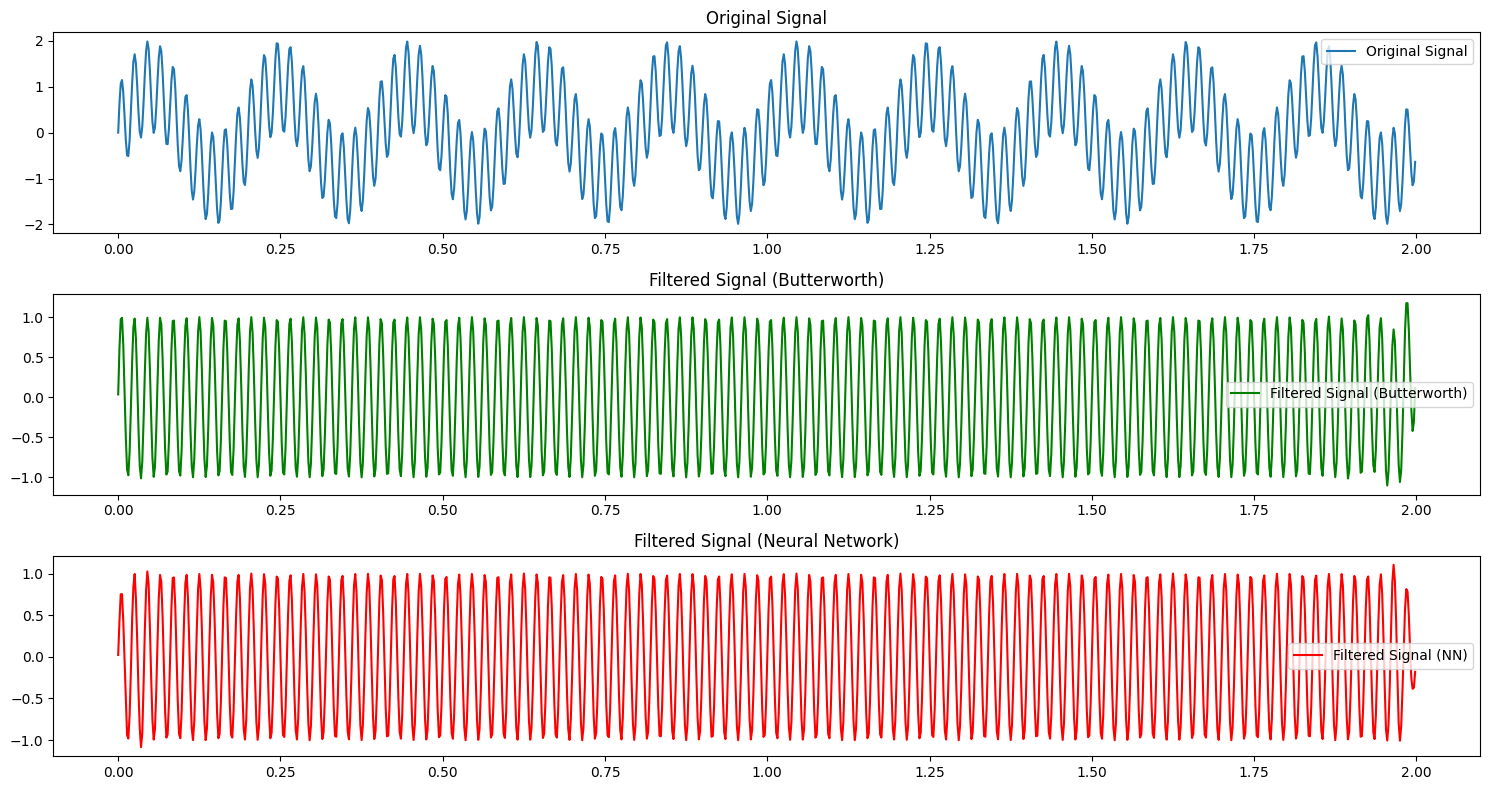

0.0012054933467879891

In [4]:
# 1. Генерация данных
Fs = 512  # Частота дискретизации
T = 2  # Продолжительность сигнала в секундах
t = np.linspace(0, T, int(Fs * T), endpoint=False)  # Временная шкала

# Сигнал: сумма низкочастотной и высокочастотной компоненты
low_freq_signal = np.sin(2 * np.pi * 5 * t)  # 5 Гц
high_freq_signal = np.sin(2 * np.pi * 50 * t)  # 50 Гц
signal = low_freq_signal + high_freq_signal

# 2. Настройка фильтра Баттерворта
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Частота Найквиста
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def butter_filter(data, cutoff, fs, btype="band", order=5):
    nyquist = fs / 2
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=btype)
    return filtfilt(b, a, data)

# Фильтрация сигнала
cutoff_freq = [15, 150]  # Частота среза 10 Гц
filtered_signal = butter_filter(signal, cutoff_freq, Fs)

# 3. Преобразование данных в тензоры
input_signal = torch.tensor(signal.copy(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (batch_size, channels, seq_len)
target_signal = torch.tensor(filtered_signal.copy(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (batch_size, channels, seq_len)

# 4. Определение нейронной сети
class LowPassFilterNet(nn.Module):
    def __init__(self, kernel_size=51):
        super(LowPassFilterNet, self).__init__()
        self.conv = nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)

    def forward(self, x):
        return self.conv(x)

# 5. Обучение нейронной сети
model = LowPassFilterNet(kernel_size=51)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Тренировочный цикл
num_epochs = 500
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(input_signal)
    loss = criterion(output, target_signal)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# 6. Результаты
model_output = model(input_signal).detach().squeeze().numpy()

# Визуализация
plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(t, signal, label='Original Signal')
plt.title('Original Signal')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, filtered_signal, label='Filtered Signal (Butterworth)', color='green')
plt.title('Filtered Signal (Butterworth)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, model_output, label='Filtered Signal (NN)', color='red')
plt.title('Filtered Signal (Neural Network)')
plt.legend()

plt.tight_layout()
plt.show()

# Печать финальной ошибки
final_loss = losses[-1]
final_loss


In [122]:
torch.manual_seed(42)
np.random.seed(42)

# Параметры
Fs = 512
T = 1000 
N_EMG = 8
N_joints = 1

# Временной вектор
t = np.linspace(0, T, int(Fs * T))

# Функция для создания фильтра
def butter_filter(order, cutoff, btype, fs):
    nyquist = fs / 2
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=btype)
    return b, a

# Генерация сырых данных ЭМГ
b_myo, a_myo = butter_filter(order=5, cutoff=[15, 150], btype='band', fs=Fs)
s = filtfilt(b_myo, a_myo, np.random.randn(N_EMG, len(t)))

# Создание пространственной матрицы смешивания
A = np.random.randn(N_joints, N_EMG)
input_signal = torch.abs(torch.matmul(torch.tensor(A.copy()), torch.tensor(s.copy())))

# Фильтрация
b_vel, a_vel = butter_filter(order=5, cutoff=2, btype='low', fs=Fs)
target_signal = torch.tensor(filtfilt(b_vel, a_vel, input_signal).copy())

input_signal = input_signal.to(torch.float32)
target_signal = target_signal.to(torch.float32)

# Параметры
window_size = 256  # Размер окна
train_ratio = 0.8  # Доля обучающей выборки

# Функция для нарезки на окна
def create_windows(data, window_size):
    num_windows = data.shape[1] // window_size
    windows = data[:, :num_windows * window_size].reshape(-1, 1, window_size)
    return windows

# Нарезка данных на окна
input_windows = create_windows(input_signal, window_size)
target_windows = create_windows(target_signal, window_size)

# Разделение на обучающую и валидационную выборки
num_train = int(train_ratio * input_windows.shape[0])
num_val = input_windows.shape[0] - num_train

train_input, val_input = torch.split(input_windows, [num_train, num_val], dim=0)
train_target, val_target = torch.split(target_windows, [num_train, num_val], dim=0)

# Создание Dataset и DataLoader
class SignalDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

train_dataset = SignalDataset(train_input, train_target)
val_dataset = SignalDataset(val_input, val_target)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Проверка
print(f"Train windows: {len(train_dataset)}, Validation windows: {len(val_dataset)}")

# Модель
class LowPassFilterNet(nn.Module):
    def __init__(self, kernel_size=101):
        super(LowPassFilterNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.tanh1 = nn.Tanh()
        self.conv2 = nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh1(x)
        x = self.conv2(x)
        return x

# Инициализация модели, функции потерь, оптимизатора и шедулера
model = LowPassFilterNet(kernel_size=101)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)

# Обучение
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- Тренировочный этап ---
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # --- Валидационный этап ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Обновление шедулера
    scheduler.step()

    # Логирование
    if epoch % 100 == 0:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

# Финальные результаты
print(f"Training complete. Final Train Loss: {train_losses[-1]:.4f}, Final Val Loss: {val_losses[-1]:.4f}")

Train windows: 1600, Validation windows: 400
Epoch 0/800, Train Loss: 0.7554, Val Loss: 0.4503, LR: 0.010000
Epoch 100/800, Train Loss: 0.0156, Val Loss: 0.0152, LR: 0.007000
Epoch 200/800, Train Loss: 0.0123, Val Loss: 0.0120, LR: 0.004900
Epoch 300/800, Train Loss: 0.0108, Val Loss: 0.0102, LR: 0.003430
Epoch 400/800, Train Loss: 0.0098, Val Loss: 0.0106, LR: 0.002401
Epoch 500/800, Train Loss: 0.0092, Val Loss: 0.0092, LR: 0.001681
Epoch 600/800, Train Loss: 0.0091, Val Loss: 0.0095, LR: 0.001176
Epoch 700/800, Train Loss: 0.0088, Val Loss: 0.0089, LR: 0.000824
Training complete. Final Train Loss: 0.0087, Final Val Loss: 0.0087


Двойная фильтрация

In [129]:
torch.manual_seed(42)
np.random.seed(42)

# Параметры
Fs = 512
T = 1000 
N_EMG = 8
N_joints = 1

# Временной вектор
t = np.linspace(0, T, int(Fs * T))

# Функция для создания фильтра
def butter_filter(order, cutoff, btype, fs):
    nyquist = fs / 2
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=btype)
    return b, a

# Генерация сырых данных ЭМГ
b_myo, a_myo = butter_filter(order=5, cutoff=[15, 150], btype='band', fs=Fs)
s = filtfilt(b_myo, a_myo, np.random.randn(N_EMG, len(t)))

# Создание пространственной матрицы смешивания
A = np.random.randn(N_joints, N_EMG)
input_signal = torch.abs(torch.matmul(torch.tensor(A.copy()), torch.tensor(s.copy())))

# Фильтрация
b_vel, a_vel = butter_filter(order=5, cutoff=2, btype='low', fs=Fs)
target_signal = torch.tensor(filtfilt(b_vel, a_vel, input_signal).copy())

b_hp, a_hp = butter_filter(order=3, cutoff=0.1, btype='high', fs=Fs)
target_signal = torch.tensor(filtfilt(b_hp, a_hp, target_signal).copy())

input_signal = input_signal.to(torch.float32)
target_signal = target_signal.to(torch.float32)

# Параметры
window_size = 256  # Размер окна
train_ratio = 0.8  # Доля обучающей выборки

# Функция для нарезки на окна
def create_windows(data, window_size):
    num_windows = data.shape[1] // window_size
    windows = data[:, :num_windows * window_size].reshape(-1, 1, window_size)
    return windows

# Нарезка данных на окна
input_windows = create_windows(input_signal, window_size)
target_windows = create_windows(target_signal, window_size)

# Разделение на обучающую и валидационную выборки
num_train = int(train_ratio * input_windows.shape[0])
num_val = input_windows.shape[0] - num_train

train_input, val_input = torch.split(input_windows, [num_train, num_val], dim=0)
train_target, val_target = torch.split(target_windows, [num_train, num_val], dim=0)

# Создание Dataset и DataLoader
class SignalDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

train_dataset = SignalDataset(train_input, train_target)
val_dataset = SignalDataset(val_input, val_target)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Проверка
print(f"Train windows: {len(train_dataset)}, Validation windows: {len(val_dataset)}")

# Модель
class LowPassFilterNet(nn.Module):
    def __init__(self, kernel_size=101):
        super(LowPassFilterNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.tanh1 = nn.Tanh()
        self.conv2 = nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.tanh2 = nn.Tanh()
        self.conv3 = nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.tanh3 = nn.Tanh()
        self.conv4 = nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh1(x)
        x = self.conv2(x)
        x = self.tanh2(x)
        x = self.conv3(x)
        x = self.tanh3(x)
        x = self.conv4(x)
        return x

# Инициализация модели, функции потерь, оптимизатора и шедулера
model = LowPassFilterNet(kernel_size=101)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.3)

# Обучение
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- Тренировочный этап ---
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # --- Валидационный этап ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Обновление шедулера
    scheduler.step()

    # Логирование
    if epoch % 100 == 0:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

# Финальные результаты
print(f"Training complete. Final Train Loss: {train_losses[-1]:.4f}, Final Val Loss: {val_losses[-1]:.4f}")

Train windows: 1600, Validation windows: 400
Epoch 0/800, Train Loss: 0.0349, Val Loss: 0.0499, LR: 0.010000
Epoch 100/800, Train Loss: 0.0136, Val Loss: 0.0126, LR: 0.003000
Epoch 200/800, Train Loss: 0.0136, Val Loss: 0.0125, LR: 0.000900
Epoch 300/800, Train Loss: 0.0132, Val Loss: 0.0121, LR: 0.000270
Epoch 400/800, Train Loss: 0.0126, Val Loss: 0.0113, LR: 0.000081
Epoch 500/800, Train Loss: 0.0121, Val Loss: 0.0109, LR: 0.000024
Epoch 600/800, Train Loss: 0.0120, Val Loss: 0.0108, LR: 0.000007
Epoch 700/800, Train Loss: 0.0120, Val Loss: 0.0108, LR: 0.000002
Training complete. Final Train Loss: 0.0123, Final Val Loss: 0.0108


Все вместе

In [167]:
torch.manual_seed(42)
np.random.seed(42)

# Параметры
Fs = 512
T = 1000 
N_EMG = 8
N_joints = 1

# Временной вектор
t = np.linspace(0, T, int(Fs * T))

# Функция для создания фильтра
def butter_filter(order, cutoff, btype, fs):
    nyquist = fs / 2
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=btype)
    return b, a

# Генерация сырых данных ЭМГ
b_myo, a_myo = butter_filter(order=5, cutoff=[15, 150], btype='band', fs=Fs)
s = filtfilt(b_myo, a_myo, np.random.randn(N_EMG, len(t)))

input_signal = torch.tensor(s.copy())
# Создание пространственной матрицы смешивания
A = np.random.randn(N_joints, N_EMG)
target_signal = torch.abs(torch.matmul(torch.tensor(A.copy()), input_signal))

# # Фильтрация
# b_vel, a_vel = butter_filter(order=5, cutoff=2, btype='low', fs=Fs)
# target_signal = torch.tensor(filtfilt(b_vel, a_vel, target_signal).copy())

# b_hp, a_hp = butter_filter(order=3, cutoff=0.1, btype='high', fs=Fs)
# target_signal = torch.tensor(filtfilt(b_hp, a_hp, target_signal).copy())

input_signal = input_signal.to(torch.float32)
target_signal = target_signal.to(torch.float32)

# Параметры
window_size = 256  # Размер окна
train_ratio = 0.8  # Доля обучающей выборки

# Функция для нарезки на окна
def create_windows(data, window_size, n_channels=1):
    num_windows = data.shape[1] // window_size
    windows = data[:, :num_windows * window_size].reshape(-1, n_channels, window_size)
    return windows

# Нарезка данных на окна
input_windows = create_windows(input_signal, window_size, n_channels=8)
target_windows = create_windows(target_signal, window_size)

# Разделение на обучающую и валидационную выборки
num_train = int(train_ratio * input_windows.shape[0])
num_val = input_windows.shape[0] - num_train

train_input, val_input = torch.split(input_windows, [num_train, num_val], dim=0)
train_target, val_target = torch.split(target_windows, [num_train, num_val], dim=0)

# Создание Dataset и DataLoader
class SignalDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

train_dataset = SignalDataset(train_input, train_target)
val_dataset = SignalDataset(val_input, val_target)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Проверка
print(f"Train windows: {len(train_dataset)}, Validation windows: {len(val_dataset)}")

# Модель
class LowPassFilterNet(nn.Module):
    def __init__(self, kernel_size=101):
        super(LowPassFilterNet, self).__init__()
        # self.A = nn.Parameter(torch.randn(1, 8, requires_grad=True))
        self.fc = nn.Linear(8, 8, bias=False)
        self.conv1 = nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.tanh1 = nn.Tanh()
        self.conv2 = nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.tanh2 = nn.Tanh()
        self.conv3 = nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.tanh3 = nn.Tanh()
        self.conv4 = nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
    
    def forward(self, x):
        # x = torch.matmul(self.A, x)
        x = self.fc(x.transpose(1, 2)).transpose(1, 2)
        x = torch.abs(x)
        
        # x = self.conv1(x)
        # x = self.tanh1(x)
        # x = self.conv2(x)
        # x = self.tanh2(x)
        # x = self.conv3(x)
        # x = self.tanh3(x)
        # x = self.conv4(x)
        return x

# Инициализация модели, функции потерь, оптимизатора и шедулера
model = LowPassFilterNet(kernel_size=101)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)

# Обучение
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- Тренировочный этап ---
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # --- Валидационный этап ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Обновление шедулера
    scheduler.step()

    # Логирование
    if epoch % 100 == 0:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

# Финальные результаты
print(f"Training complete. Final Train Loss: {train_losses[-1]:.4f}, Final Val Loss: {val_losses[-1]:.4f}")

Train windows: 1600, Validation windows: 400
Epoch 0/800, Train Loss: 2.0337, Val Loss: 1.9324, LR: 0.010000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([128, 1, 256])) that is different to the input size (torch.Size([128, 8, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 1, 256])) that is different to the input size (torch.Size([64, 8, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 256])) that is different to the input s

Epoch 100/800, Train Loss: 1.6945, Val Loss: 1.7220, LR: 0.007000
Epoch 200/800, Train Loss: 1.6922, Val Loss: 1.7221, LR: 0.004900
Epoch 300/800, Train Loss: 1.6917, Val Loss: 1.7218, LR: 0.003430
Epoch 400/800, Train Loss: 1.6921, Val Loss: 1.7219, LR: 0.002401
Epoch 500/800, Train Loss: 1.6907, Val Loss: 1.7219, LR: 0.001681
Epoch 600/800, Train Loss: 1.6899, Val Loss: 1.7218, LR: 0.001176
Epoch 700/800, Train Loss: 1.6909, Val Loss: 1.7219, LR: 0.000824
Training complete. Final Train Loss: 1.6918, Final Val Loss: 1.7218


In [3]:
torch.manual_seed(42)
np.random.seed(42)

# Параметры
Fs = 512
T = 1000 
N_EMG = 8
N_joints = 1

# Временной вектор
t = np.linspace(0, T, int(Fs * T))

# Функция для создания фильтра
def butter_filter(order, cutoff, btype, fs):
    nyquist = fs / 2
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=btype)
    return b, a

# Генерация сырых данных ЭМГ
b_myo, a_myo = butter_filter(order=5, cutoff=[15, 150], btype='band', fs=Fs)
s = filtfilt(b_myo, a_myo, np.random.randn(N_EMG, len(t)))

input_signal = torch.tensor(s.copy())
# Создание пространственной матрицы смешивания
A = np.random.randn(N_joints, N_EMG)
target_signal = torch.abs(torch.matmul(torch.tensor(A.copy()), input_signal))

input_signal.shape, target_signal.shape

(torch.Size([8, 512000]), torch.Size([1, 512000]))

In [42]:
torch.manual_seed(42)
np.random.seed(42)

# Параметры
Fs = 512
T = 1000 
N_EMG = 8
N_joints = 1

# Временной вектор
t = np.linspace(0, T, int(Fs * T))

# Функция для создания фильтра
def butter_filter(order, cutoff, btype, fs):
    nyquist = fs / 2
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=btype)
    return b, a

# Генерация сырых данных ЭМГ
b_myo, a_myo = butter_filter(order=5, cutoff=[15, 150], btype='band', fs=Fs)
s = filtfilt(b_myo, a_myo, np.random.randn(N_EMG, len(t)))

input_signal = torch.tensor(s.copy())
# Создание пространственной матрицы смешивания
A = np.random.randn(N_joints, N_EMG)
target_signal = torch.abs(torch.matmul(torch.tensor(A.copy()), input_signal))

# Разделение данных на обучающую и валидационную выборки
train_ratio = 0.8
train_size = int(input_signal.shape[1] * train_ratio)
val_size = input_signal.shape[1] - train_size

train_input = input_signal[:, :train_size]
train_target = target_signal[:, :train_size]
val_input = input_signal[:, train_size:]
val_target = target_signal[:, train_size:]

train_input.shape, train_target.shape, val_input.shape, val_target.shape   

# Разбиение на окна
window_size = 256

def create_windows(signal, target, window_size):
    x, y = [], []
    for i in range(0, signal.shape[1] - window_size + 1, window_size):
        x.append(signal[:, i:i+window_size])
        y.append(target[:, i:i+window_size])
    return torch.stack(x), torch.stack(y)

train_x, train_y = create_windows(train_input, train_target, window_size)
val_x, val_y = create_windows(val_input, val_target, window_size)

train_x.shape, train_y.shape, val_x.shape, val_y.shape  

class EMGDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].to(torch.float32), self.y[idx].to(torch.float32)

train_dataset = EMGDataset(train_x, train_y)
val_dataset = EMGDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.weight = nn.Parameter(torch.randn(N_joints, N_EMG), requires_grad=True)

    def forward(self, x):
        # x.shape: [batch_size(64), N_EMG(8), window_size(256)] 
        x = torch.abs(torch.matmul(self.weight, x))
        return x
    
# Гиперпараметры
input_size = N_EMG * window_size
hidden_size = 128
output_size = N_joints * window_size
epochs = 150
learning_rate = 0.001

model = SimpleNN(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Тренировка модели
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    if epoch % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Модель обучена и готова к использованию


Epoch 1/500, Train Loss: 2.1572, Val Loss: 2.1374
Epoch 51/500, Train Loss: 0.3621, Val Loss: 0.3534
Epoch 101/500, Train Loss: 0.0107, Val Loss: 0.0103
Epoch 151/500, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 201/500, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 251/500, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 301/500, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 351/500, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 401/500, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 451/500, Train Loss: 0.0000, Val Loss: 0.0000


In [46]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Параметры
Fs = 512
T = 1000 
N_EMG = 8
N_joints = 1

# Временной вектор
t = np.linspace(0, T, int(Fs * T))

# Функция для создания фильтра
def butter_filter(order, cutoff, btype, fs):
    nyquist = fs / 2
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=btype)
    return b, a

# Генерация сырых данных ЭМГ
b_myo, a_myo = butter_filter(order=5, cutoff=[15, 150], btype='band', fs=Fs)
b_vel, a_vel = butter_filter(order=1, cutoff=2, btype='low', fs=Fs)
b_hp, a_hp = butter_filter(order=3, cutoff=0.1, btype='high', fs=Fs)

s = lfilter(b_myo, a_myo, np.random.randn(N_EMG, len(t)))

input_signal = torch.tensor(s.copy())
# Создание пространственной матрицы смешивания
A = np.random.randn(N_joints, N_EMG)
target_signal = torch.abs(torch.matmul(torch.tensor(A.copy()), input_signal))
target_signal = torch.tensor(lfilter(b_vel, a_vel, target_signal, axis=1))
target_signal = torch.tensor(lfilter(b_hp, a_hp, target_signal, axis=1))

# Разделение данных на обучающую и валидационную выборки
train_ratio = 0.8
train_size = int(input_signal.shape[1] * train_ratio)
val_size = input_signal.shape[1] - train_size

train_input = input_signal[:, :train_size]
train_target = target_signal[:, :train_size]
val_input = input_signal[:, train_size:]
val_target = target_signal[:, train_size:]

train_input.shape, train_target.shape, val_input.shape, val_target.shape   

# Разбиение на окна
window_size = 256

def create_windows(signal, target, window_size):
    x, y = [], []
    for i in range(0, signal.shape[1] - window_size + 1, window_size):
        x.append(signal[:, i:i+window_size])
        y.append(target[:, i:i+window_size])
    return torch.stack(x), torch.stack(y)

train_x, train_y = create_windows(train_input, train_target, window_size)
val_x, val_y = create_windows(val_input, val_target, window_size)

train_x.shape, train_y.shape, val_x.shape, val_y.shape  

class EMGDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].to(torch.float32), self.y[idx].to(torch.float32)

train_dataset = EMGDataset(train_x, train_y)
val_dataset = EMGDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
#         super(ConvBlock, self).__init__()
#         self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, bias=False)
#         self.bn = nn.BatchNorm1d(out_channels)
#         self.relu = nn.ELU()

#     def forward(self, x):
#         out = self.conv(x)
#         out = self.bn(out)
#         out = self.relu(out)
#         return out + x  

# class SimpleNN(nn.Module):
#     def __init__(self, kernel_size=3, num_layers=20):
#         super(SimpleNN, self).__init__()
        
#         self.weight = nn.Parameter(torch.randn(N_joints, N_EMG), requires_grad=True)

#         self.conv = nn.Conv1d(1, 1, kernel_size, padding=1, bias=False)
#         self.bn = nn.BatchNorm1d(1)

#         # Создаем и объединяем блоки
#         self.layers = nn.ModuleList([ConvBlock(1, 1, kernel_size) for _ in range(num_layers)])

#         # Полносвязный слой (закомментирован, т.к. не используется)
#         # self.fc = nn.Linear(256, 256, bias=True)

#     def forward(self, x):
#         # x.shape: [batch_size(64), N_EMG(8), window_size(256)]
#         x = torch.abs(torch.matmul(self.weight, x))

#         # Последовательное применение блоков
#         for layer in self.layers:
#             x = layer(x)
#         x = self.conv(x)
#         x = self.bn(x)

#         # Закомментированные строки для развертывания и скучивания обратно
#         # x = x.view(x.size(0), -1)
#         # x = self.fc(x)
#         # x = x.view(-1, 1, 256)

#         return x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, bias=False)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ELU()

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, 
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.elu = nn.ELU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1,
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.elu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.elu(out)

        return out

class SimpleNN(nn.Module):
    def __init__(self, kernel_size=3, num_blocks=25, block_expansion=1):
        super(SimpleNN, self).__init__()

        self.weight = nn.Parameter(torch.randn(N_joints, N_EMG), requires_grad=True)

        self.conv1 = nn.Conv1d(1, block_expansion, kernel_size, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(block_expansion)
        self.elu = nn.ELU()

        # Создаем и объединяем остаточные блоки
        self.res_layers = self._make_layer(ResidualBlock, block_expansion, num_blocks, kernel_size)

        self.conv = nn.Conv1d(block_expansion, 1, kernel_size, padding=1, bias=False)
        self.bn = nn.BatchNorm1d(1)

    def _make_layer(self, block, out_channels, num_blocks, kernel_size):
        layers = []
        in_channels = out_channels
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels, kernel_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x.shape: [batch_size(64), N_EMG(8), window_size(256)]
        x = torch.abs(torch.matmul(self.weight, x))

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.elu(x)

        x = self.res_layers(x)

        x = self.conv(x)
        x = self.bn(x)

        return x
    
# Гиперпараметры
epochs = 1_500
learning_rate = 0.001

model = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100, verbose=True, min_lr=1e-6)

def train():
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Обновление шедулера
        scheduler.step()
        # scheduler.step(val_loss)

        # Логирование
        if epoch % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            # current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

train()


Epoch 0/1500, Train Loss: 1.0005, Val Loss: 0.4462, LR: 0.001000
Epoch 100/1500, Train Loss: 0.0076, Val Loss: 0.0066, LR: 0.000900
Epoch 200/1500, Train Loss: 0.0064, Val Loss: 0.0052, LR: 0.000810
Epoch 300/1500, Train Loss: 0.0061, Val Loss: 0.0054, LR: 0.000729
Epoch 400/1500, Train Loss: 0.0061, Val Loss: 0.0052, LR: 0.000656
Epoch 500/1500, Train Loss: 0.0060, Val Loss: 0.0049, LR: 0.000590
Epoch 600/1500, Train Loss: 0.0060, Val Loss: 0.0051, LR: 0.000531
Epoch 700/1500, Train Loss: 0.0060, Val Loss: 0.0048, LR: 0.000478
Epoch 800/1500, Train Loss: 0.0060, Val Loss: 0.0048, LR: 0.000430
Epoch 900/1500, Train Loss: 0.0060, Val Loss: 0.0050, LR: 0.000387
Epoch 1000/1500, Train Loss: 0.0060, Val Loss: 0.0048, LR: 0.000349
Epoch 1100/1500, Train Loss: 0.0060, Val Loss: 0.0050, LR: 0.000314
Epoch 1200/1500, Train Loss: 0.0060, Val Loss: 0.0055, LR: 0.000282
Epoch 1300/1500, Train Loss: 0.0059, Val Loss: 0.0048, LR: 0.000254
Epoch 1400/1500, Train Loss: 0.0060, Val Loss: 0.0050, LR: 0

In [36]:
model.parameters

<bound method Module.parameters of SimpleNN(
  (conv1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (bn1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (res_layers): Sequential(
    (0): ResidualBlock(
      (conv1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (elu): ELU(alpha=1.0)
      (conv2): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (elu): ELU(alpha=1.0)
      (conv2): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (b

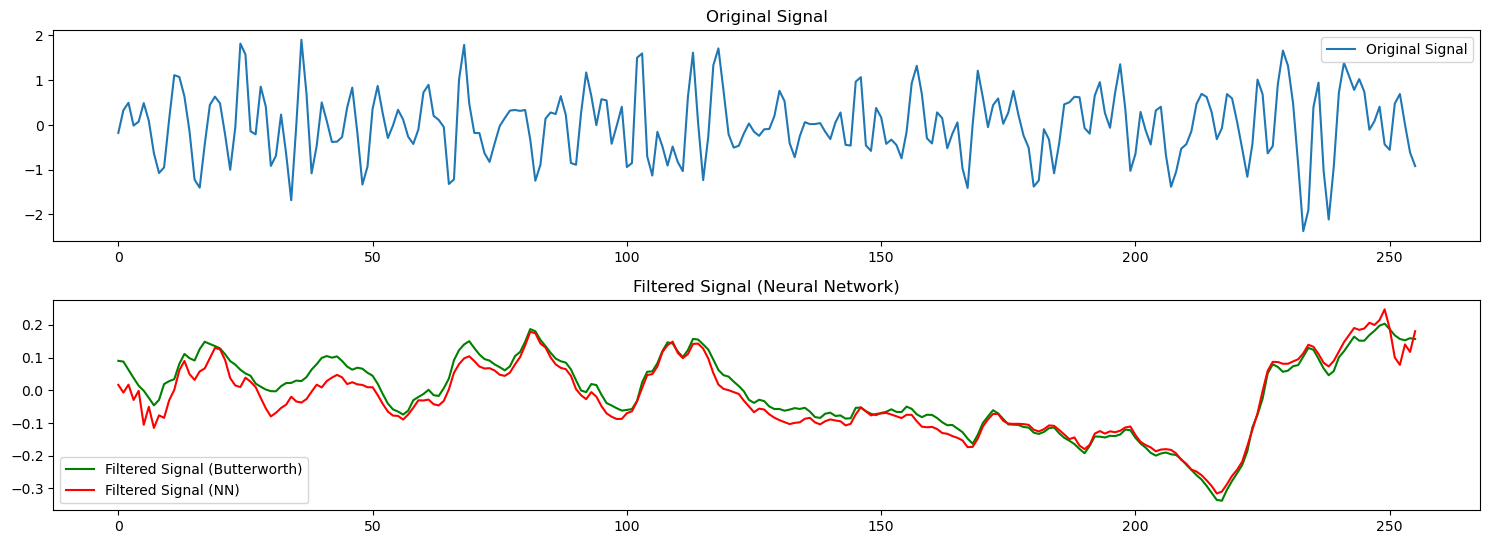

In [49]:
input_signal, target = next(iter(val_loader))

model_output = model(input_signal.to(device)).detach().cpu()

# Визуализация
i = 37
plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(range(len(input_signal[1][0])), input_signal[i][0], label='Original Signal')
plt.title('Original Signal')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(len(target[1][0])), target[i][0], label='Filtered Signal (Butterworth)', color='green')
plt.title('Filtered Signal (Butterworth)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(len(model_output[1][0])), model_output[i][0], label='Filtered Signal (NN)', color='red')
plt.title('Filtered Signal (Neural Network)')
plt.legend()

plt.tight_layout()
plt.show()



In [48]:
# Пример данных (замени на свои настоящие данные)
i = 6

def corr_coef(true_signal, predicted_signal):

    # Убираем размерность 1
    true_signal = true_signal.squeeze()
    predicted_signal = predicted_signal.squeeze()

    # Вычисляем средние значения
    mean_true = true_signal.mean()
    mean_predicted = predicted_signal.mean()

    # Считаем отклонения от среднего
    deviation_true = true_signal - mean_true
    deviation_predicted = predicted_signal - mean_predicted

    # Вычисляем числитель и знаменатель формулы для корреляции
    numerator = (deviation_true * deviation_predicted).sum()
    denominator = torch.sqrt((deviation_true ** 2).sum() * (deviation_predicted ** 2).sum())

    # Вычисляем коэффициент корреляции
    correlation = numerator / denominator
    return correlation

max_corr = 0
for i in range(64):
    corr = corr_coef(target[i], model_output[i])
    if corr > max_corr:
        max_corr = corr
        best_i = i

max_corr, best_i


(tensor(0.9712), 37)

In [21]:
target.shape, model_output.shape

(torch.Size([64, 1, 256]), torch.Size([64, 1, 256]))

In [ ]:
arr = torch.randn(size=(10, 1, 10))
delta1 = 8
delta2 = 2
torch.split(arr, [delta1, delta2], dim=0)[0]